In [1]:
import seaborn as sns
import csv
import os
import pandas as pd
from scipy.stats import gaussian_kde
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import json
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
experimental_affinities = {}
mmpbsa_affinities = {}
with open('../final_experimental.csv', 'r') as f:
    csv_reader = csv.DictReader(f)
    for row in csv_reader:
        experimental_affinities[row['Pdbid']] = float(row['Experimental'])
        mmpbsa_affinities[row['Pdbid']] = float(row['DELTA_TOTAL'])

In [3]:
RT = 1.987 * 300 / 1000

In [4]:
for filename in os.listdir("."):
    if filename.startswith("output") and filename.endswith(".csv"):
        inputfile = filename

In [5]:
with open('results.csv', 'w', newline='') as f:
    csv_writer = csv.DictWriter(f, fieldnames=['Pdbid_Frame', 'Real', 'Predicted', 'Set'])
    csv_writer.writeheader()
    
    with open(inputfile, 'r') as g:
        csv_reader = csv.DictReader(g)
        for row in csv_reader:
            pdbid = row['pdbid']
            predicted = float(row['predicted'])
            set_value = row['set']
            real_value = experimental_affinities.get(pdbid[:4], 0.0)
            csv_writer.writerow({'Pdbid_Frame': pdbid, 'Real': real_value, 'Predicted': -predicted * RT * 2.303, 'Set': set_value})


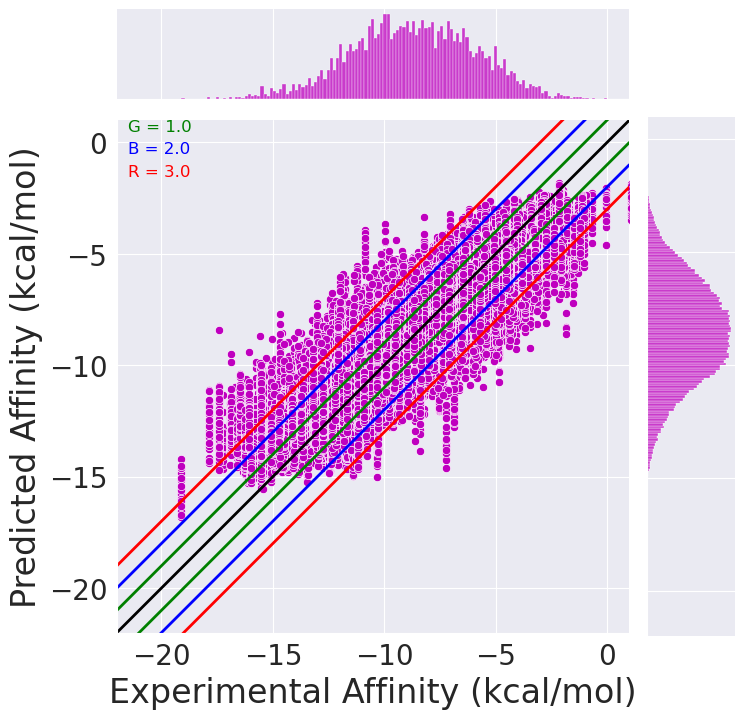

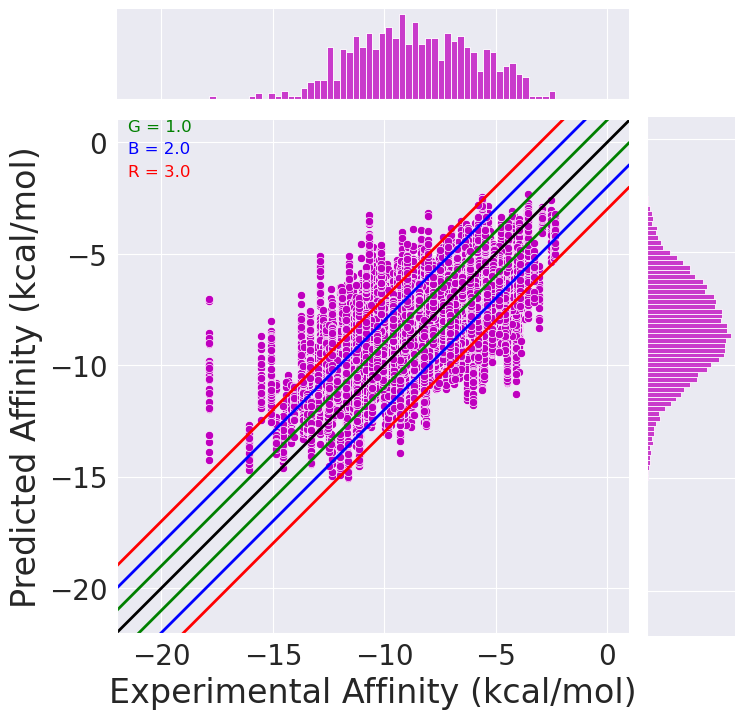

In [6]:
data = pd.read_csv('results.csv')
data_training = data[data['Set'] == 'training']
data_test = data[data['Set'] == 'test']

lower_limit = -22
upper_limit = 1

# Set font sizes
label_fontsize = 24
tick_fontsize = 20

g = sns.jointplot(x="Real", y="Predicted", data=data_training, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize)
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize)
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red')
g.savefig('training.png')

g = sns.jointplot(x="Real", y="Predicted", data=data_test, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize)
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize)
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red')
g.savefig('test.png')


In [7]:
mse_training = mean_squared_error(data_training['Real'], data_training['Predicted'])
mse_test = mean_squared_error(data_test['Real'], data_test['Predicted'])

print(f'MSE Training: {mse_training:.2f}')
print(f'MSE Test: {mse_test:.2f}')

rmse_training = np.sqrt(mse_training)
rmse_test = np.sqrt(mse_test)

print(f'RMSE Training: {rmse_training:.2f}')
print(f'RMSE Test: {rmse_test:.2f}')

MSE Training: 1.83
MSE Test: 3.99
RMSE Training: 1.35
RMSE Test: 2.00


In [8]:
old_data = pd.read_csv('results.csv')
pred_affinity_values = {}
pdbid_set = {}
for index, row in old_data.iterrows():
    pdbid = row['Pdbid_Frame'][:4]
    pred_affinity_values[pdbid] = pred_affinity_values.get(pdbid, []) + [row['Predicted']]
    if pdbid not in pdbid_set:
        pdbid_set[pdbid] = row['Set']

In [9]:
# Dictionary to store final affinity values for each PDB ID
final_affinity_values = {}

for pdbid, values in pred_affinity_values.items():
    # Compute KDE using scipy.stats.gaussian_kde
    kde = gaussian_kde(values)

    # Generate a set of x values for evaluation
    x_vals = np.linspace(min(values), max(values), 1000)

    # Evaluate the KDE at the x values
    y_vals = kde(x_vals)

    # Find the x value (peak) corresponding to the maximum y value
    peak_value = x_vals[np.argmax(y_vals)]

    # Store the peak value as the final affinity value for the current PDB ID
    final_affinity_values[pdbid] = peak_value


In [10]:
with open("results_guassian.csv", "w", newline='') as f:
    csv_writer = csv.DictWriter(f, fieldnames=["Pdbid", "Real", "Predicted", "Set"])
    csv_writer.writeheader()
    for pdbid, value in final_affinity_values.items():
        csv_writer.writerow(
            {
                "Pdbid": pdbid,
                "Real": experimental_affinities[pdbid],
                "Predicted": value,
                "Set": pdbid_set[pdbid],
            }
        )

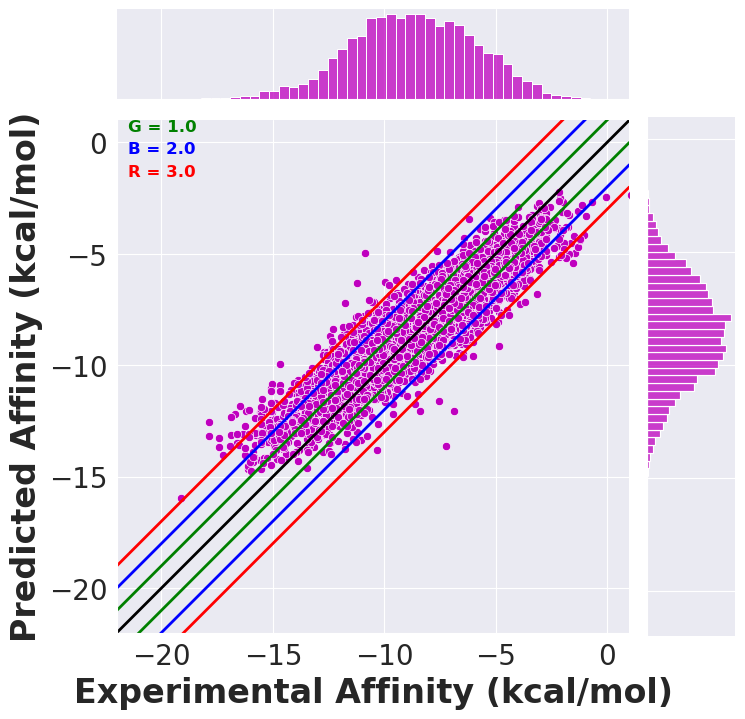

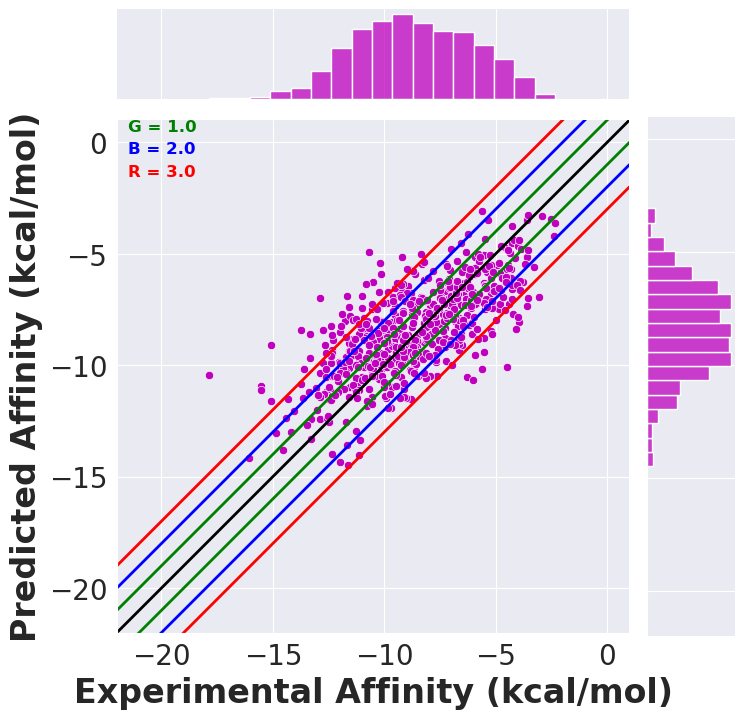

In [11]:
data_guassian = pd.read_csv('results_guassian.csv')
data_training_guassian = data_guassian[data_guassian['Set'] == 'training']
data_test_guassian = data_guassian[data_guassian['Set'] == 'test']

lower_limit = -22
upper_limit = 1

label_fontsize = 24
tick_fontsize = 20

g = sns.jointplot(x="Real", y="Predicted", data=data_training_guassian, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('training_guassian.png')

g = sns.jointplot(x="Real", y="Predicted", data=data_test_guassian, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('test_guassian.png')

In [12]:
mse_training_guassian = mean_squared_error(data_training_guassian['Real'], data_training_guassian['Predicted'])
mse_test_guassian = mean_squared_error(data_test_guassian['Real'], data_test_guassian['Predicted'])

print(f'MSE Training: {mse_training_guassian:.2f}')
print(f'MSE Test: {mse_test_guassian:.2f}')

rmse_training_guassian = np.sqrt(mse_training_guassian)
rmse_test_guassian = np.sqrt(mse_test_guassian)

print(f'RMSE Training: {rmse_training_guassian:.2f}')
print(f'RMSE Test: {rmse_test_guassian:.2f}')

MSE Training: 1.50
MSE Test: 3.63
RMSE Training: 1.22
RMSE Test: 1.91


In [13]:
mean_affinity_values = {}

for pdbid, values in pred_affinity_values.items():
    # Compute the mean of the values
    mean_affinity_values[pdbid] = np.mean(values)

In [14]:
with open("results_mean.csv", "w", newline='') as f:
    csv_writer = csv.DictWriter(f, fieldnames=["Pdbid", "Real", "Predicted", "Set"])
    csv_writer.writeheader()
    for pdbid, value in mean_affinity_values.items():
        csv_writer.writerow(
            {
                "Pdbid": pdbid,
                "Real": experimental_affinities[pdbid],
                "Predicted": value,
                "Set": pdbid_set[pdbid],
            }
        )

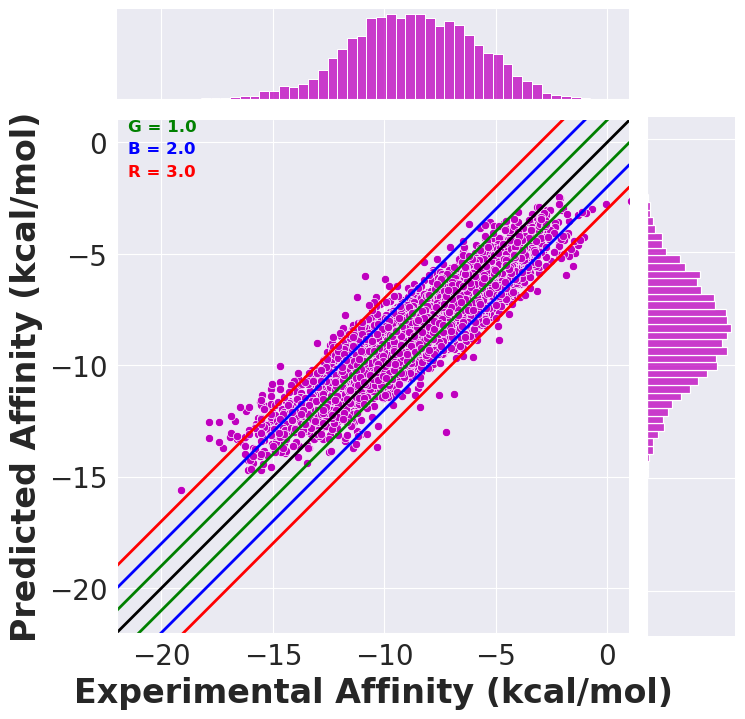

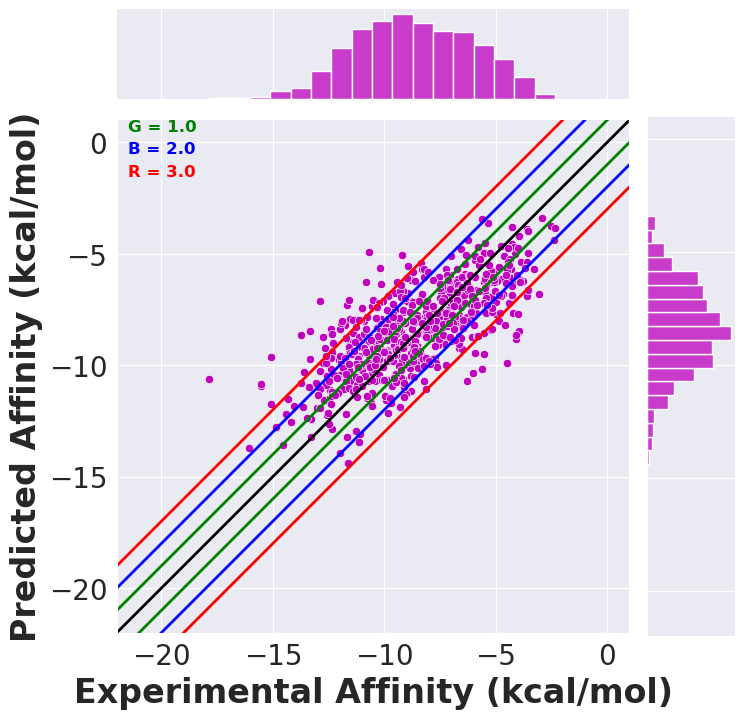

In [15]:
data_mean = pd.read_csv('results_mean.csv')
data_training_mean = data_mean[data_mean['Set'] == 'training']
data_test_mean = data_mean[data_mean['Set'] == 'test']

lower_limit = -22
upper_limit = 1

label_fontsize = 24
tick_fontsize = 20

g = sns.jointplot(x="Real", y="Predicted", data=data_training_mean, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('training_mean.png')

g = sns.jointplot(x="Real", y="Predicted", data=data_test_mean, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('test_mean.png')

In [16]:
mse_training_mean = mean_squared_error(data_training_mean['Real'], data_training_mean['Predicted'])
mse_test_mean = mean_squared_error(data_test_mean['Real'], data_test_mean['Predicted'])

print(f'MSE Training: {mse_training_mean:.2f}')
print(f'MSE Test: {mse_test_mean:.2f}')

rmse_training_mean = np.sqrt(mse_training_mean)
rmse_test_mean = np.sqrt(mse_test_mean)

print(f'RMSE Training: {rmse_training_mean:.2f}')
print(f'RMSE Test: {rmse_test_mean:.2f}')

MSE Training: 1.49
MSE Test: 3.50
RMSE Training: 1.22
RMSE Test: 1.87


In [17]:
# Dictionary to store final affinity values for each PDB ID
final_affinity_values = {}

for pdbid, values in pred_affinity_values.items():
    # Fit Bayesian Gaussian Mixture Model
    bgmm = BayesianGaussianMixture(n_components=5, max_iter=2000)
    bgmm.fit(np.array(values).reshape(-1, 1))

    # Get the component with the highest weight
    highest_weight_idx = np.argmax(bgmm.weights_)
    peak_value = bgmm.means_[highest_weight_idx][0]

    # Store the peak value as the final affinity value for the current PDB ID
    final_affinity_values[pdbid] = peak_value


In [18]:
# Open and write data to 'results_guassian.csv' file
with open("results_bayesian.csv", "w", newline='') as f:
    csv_writer = csv.DictWriter(f, fieldnames=["Pdbid", "Real", "Predicted", "Set"])
    csv_writer.writeheader()
    for pdbid, value in final_affinity_values.items():
        csv_writer.writerow(
            {
                "Pdbid": pdbid,
                "Real": experimental_affinities[pdbid],
                "Predicted": value,
                "Set": pdbid_set[pdbid],
            }
        )

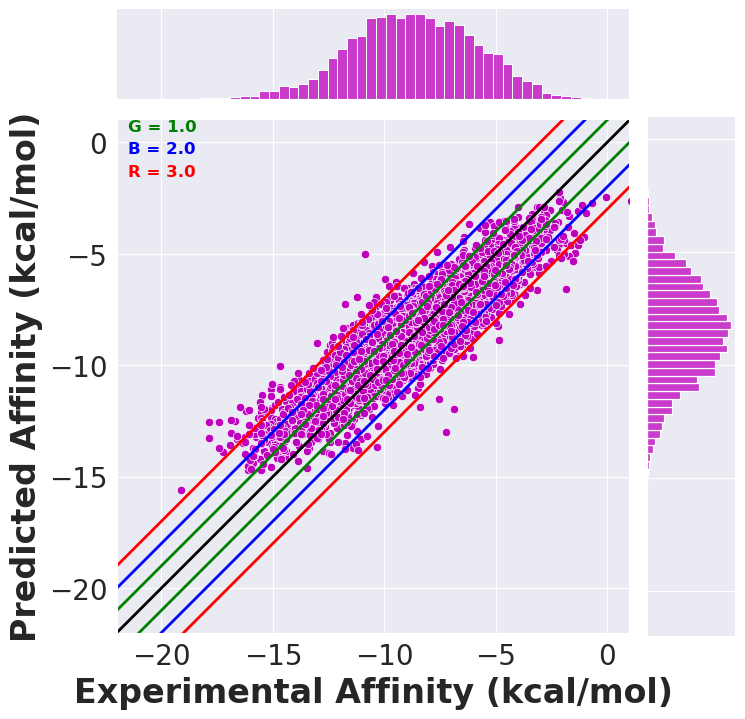

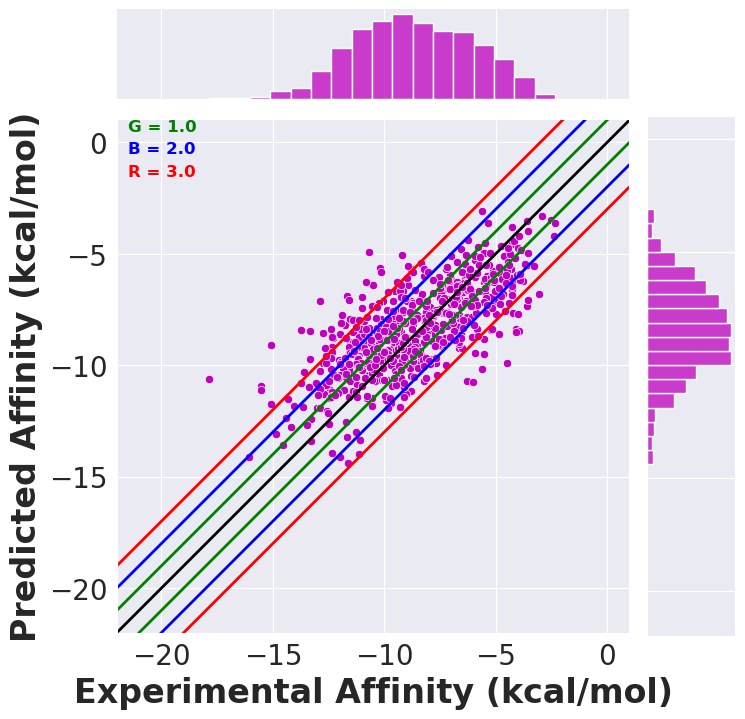

In [19]:
# Read the data from 'results_guassian.csv'
data_bayesian = pd.read_csv('results_bayesian.csv')

# Split data into training and test sets
data_training_bayesian = data_bayesian[data_bayesian['Set'] == 'training']
data_test_bayesian = data_bayesian[data_bayesian['Set'] == 'test']

# Define lower and upper limits
lower_limit = -22
upper_limit = 1

label_fontsize = 24
tick_fontsize = 20

g = sns.jointplot(x="Real", y="Predicted", data=data_training_bayesian, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('training_bayesian.png')

g = sns.jointplot(x="Real", y="Predicted", data=data_test_bayesian, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('test_bayesian.png')

In [20]:
mse_training_bayesian = mean_squared_error(data_training_bayesian['Real'], data_training_bayesian['Predicted'])
mse_test_bayesian = mean_squared_error(data_test_bayesian['Real'], data_test_bayesian['Predicted'])

print(f'MSE Training: {mse_training_bayesian:.2f}')
print(f'MSE Test: {mse_test_bayesian:.2f}')

rmse_training_bayesian = np.sqrt(mse_training_bayesian)
rmse_test_bayesian = np.sqrt(mse_test_bayesian)

print(f'RMSE Training: {rmse_training_bayesian:.2f}')
print(f'RMSE Test: {rmse_test_bayesian:.2f}')

MSE Training: 1.50
MSE Test: 3.57
RMSE Training: 1.22
RMSE Test: 1.89


In [21]:
output_dir = "plc_model_results_20250917_183527"

def get_activation(activation_name):
    if activation_name == "relu":
        return nn.ReLU()
    elif activation_name == "gelu":
        return nn.GELU()
    elif activation_name == "silu":
        return nn.SiLU()
    elif activation_name == "leaky_relu":
        return nn.LeakyReLU(0.1)
    else:
        raise ValueError(f"Unknown activation: {activation_name}")

class BasicANN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation="gelu"):
        super().__init__()
        layers = []
        prev_dim = input_dim
        activation_fn = get_activation(activation)
        for i, (hidden_dim, dropout_rate) in enumerate(zip(hidden_dims, dropout_rates)):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(activation_fn)
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

class ResidualANN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation="gelu"):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        activation_fn = get_activation(activation)
        for i, (hidden_dim, dropout_rate) in enumerate(zip(hidden_dims, dropout_rates)):
            block = nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                activation_fn,
                nn.Dropout(dropout_rate)
            )
            self.layers.append(block)
            if prev_dim == hidden_dim:
                self.layers.append(nn.Identity())
            else:
                self.layers.append(nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim
        self.final_layer = nn.Linear(prev_dim, 1)
    def forward(self, x):
        for i in range(0, len(self.layers), 2):
            block = self.layers[i]
            skip = self.layers[i + 1]
            x = block(x) + skip(x)
        return self.final_layer(x)

class WideAndDeepANN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation="gelu"):
        super().__init__()
        self.wide = nn.Sequential(nn.Linear(input_dim, hidden_dims[-1]), get_activation(activation))
        deep_layers = []
        prev_dim = input_dim
        activation_fn = get_activation(activation)
        for i, (hidden_dim, dropout_rate) in enumerate(zip(hidden_dims, dropout_rates)):
            deep_layers.append(nn.Linear(prev_dim, hidden_dim))
            deep_layers.append(nn.LayerNorm(hidden_dim))
            deep_layers.append(activation_fn)
            deep_layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine = nn.Linear(hidden_dims[-1] * 2, 1)
    def forward(self, x):
        wide_out = self.wide(x)
        deep_out = self.deep(x)
        combined = torch.cat([wide_out, deep_out], dim=1)
        return self.combine(combined)

def create_model(model_type, input_dim, hidden_dims, dropout_rates, activation):
    if model_type == "basic_ann":
        return BasicANN(input_dim, hidden_dims, dropout_rates, activation)
    elif model_type == "residual":
        return ResidualANN(input_dim, hidden_dims, dropout_rates, activation)
    elif model_type == "wide_deep":
        return WideAndDeepANN(input_dim, hidden_dims, dropout_rates, activation)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

model_path = os.path.join(output_dir, "plc_model.pth")
config_path = os.path.join(output_dir, "config.json")

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Error: Model file not found at {model_path}\nPlease check the 'output_dir' variable.")

with open(config_path, 'r') as f:
    config = json.load(f)

# Load the saved checkpoint
checkpoint = torch.load(model_path, map_location=torch.device('cpu')) # Load to CPU
scaler = checkpoint['scaler']
input_dim = checkpoint['input_dim']

# Initialize model from config
model = create_model(
    config["MODEL_TYPE"],
    input_dim,
    config["HIDDEN_DIMS"],
    config["DROPOUT_RATES"],
    config["ACTIVATION"]
)

# Load the trained weights and set to evaluation mode
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

df = pd.read_csv('results.csv')
df['PDBID'] = df['Pdbid_Frame'].apply(lambda x: x.split('_')[0])
grouped = df.groupby('PDBID')

processed_data = []

for pdbid, group in grouped:
    preds = group['Predicted'].values
    if len(preds) > config["MAX_N_FRAMES"]:
        preds = preds[:config["MAX_N_FRAMES"]]
    else:
        preds = np.pad(preds, (0, config["MAX_N_FRAMES"] - len(preds)), 'constant', constant_values=0.0)

    # Recreate features exactly as in training
    features = []
    features.extend(preds)
    if config.get("USE_STAT_FEATURES", False):
        basic_stats = [np.min(preds), np.max(preds), np.mean(preds), np.std(preds)]
        if config.get("USE_EXTENDED_STATS", False):
            extended_stats = [
                np.median(preds),
                np.mean(np.abs(preds - np.mean(preds))),
                np.sqrt(np.mean(preds**2)),
                (np.max(preds) - np.min(preds)),
            ]
            basic_stats.extend(extended_stats)
        if config.get("USE_PERCENTILES", False):
            basic_stats.extend(np.percentile(preds, [10, 25, 50, 75, 90]))
        if config.get("USE_HISTOGRAM", False):
            hist, _ = np.histogram(preds, bins=5, range=(np.min(preds), np.max(preds)))
            basic_stats.extend(hist)
        features.extend(basic_stats)

    processed_data.append({
        "pdbid": pdbid,
        "features": np.array(features, dtype=np.float32),
        "real": group['Real'].iloc[0],
        "set": group['Set'].iloc[0]
    })

X_features = np.array([d['features'] for d in processed_data])
X_scaled = scaler.transform(X_features)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

with torch.no_grad():
    ann_predictions = model(X_tensor).numpy().flatten()


/tmp/ipykernel_15125/2163859295.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu')) # Load to CPU


In [22]:
results_list = []
for i, data_point in enumerate(processed_data):
    results_list.append({
        "Pdbid": data_point['pdbid'],
        "Real": data_point['real'],
        "Predicted": ann_predictions[i],
        "Set": data_point['set']
    })
df_ann = pd.DataFrame(results_list)
df_ann.to_csv("results_ann.csv", index=False)


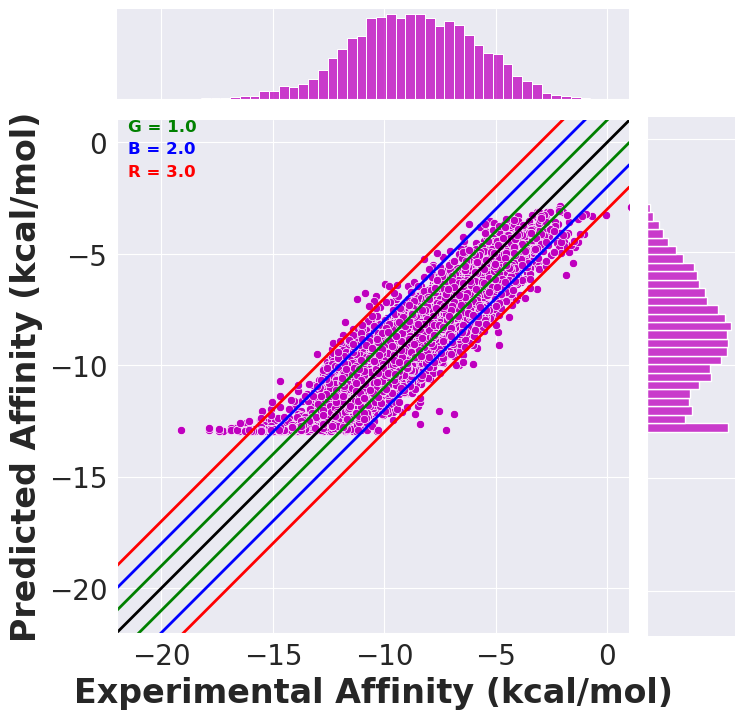

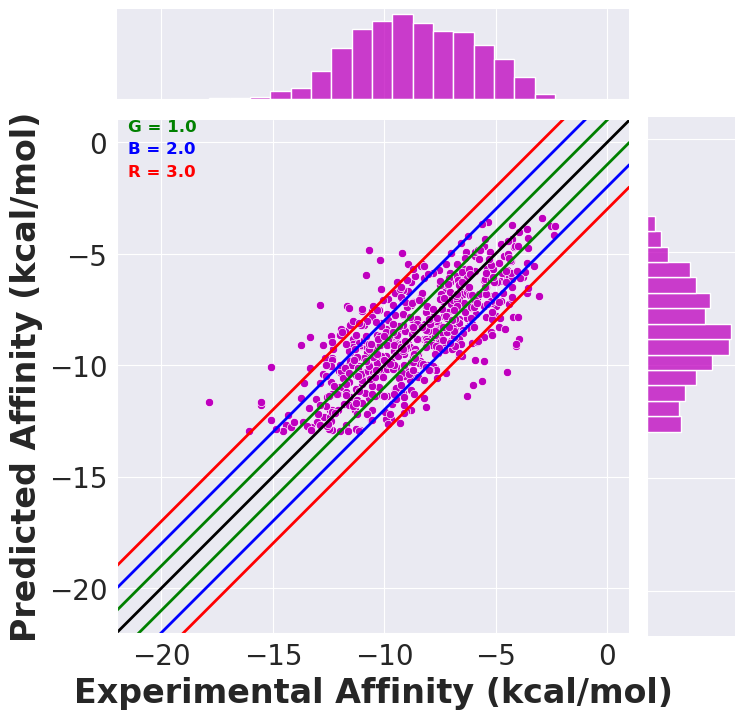

In [23]:
data_ann = pd.read_csv('results_ann.csv')
data_training_ann = data_ann[data_ann['Set'] == 'training']
data_test_ann = data_ann[data_ann['Set'] == 'test']

# Define plotting parameters
lower_limit = -22
upper_limit = 1

label_fontsize = 24
tick_fontsize = 20

g = sns.jointplot(x="Real", y="Predicted", data=data_training_ann, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('training_ann.png')

g = sns.jointplot(x="Real", y="Predicted", data=data_test_ann, color="m", height=7)
g.ax_joint.set_xlabel('Experimental Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.set_ylabel('Predicted Affinity (kcal/mol)', fontsize=label_fontsize, fontweight='bold')
g.ax_joint.tick_params(labelsize=tick_fontsize)  # Set tick font size
g.ax_joint.set_xlim(lower_limit, upper_limit)
g.ax_joint.set_ylim(lower_limit, upper_limit)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit, upper_limit], linewidth=2, color='black')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 1.0, upper_limit + 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 1.0, upper_limit - 1.0], linewidth=2, color='green')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 2.0, upper_limit + 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 2.0, upper_limit - 2.0], linewidth=2, color='blue')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit + 3.0, upper_limit + 3.0], linewidth=2, color='red')
g.ax_joint.plot([lower_limit, upper_limit], [lower_limit - 3.0, upper_limit - 3.0], linewidth=2, color='red')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 0.5, 'G = 1.0', fontsize=12, color='green', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 1.5, 'B = 2.0', fontsize=12, color='blue', fontweight='bold')
g.ax_joint.text(lower_limit + 0.5, upper_limit - 2.5, 'R = 3.0', fontsize=12, color='red', fontweight='bold')
g.savefig('test_ann.png')

In [24]:
mse_training_ann = mean_squared_error(data_training_ann['Real'], data_training_ann['Predicted'])
mse_test_ann = mean_squared_error(data_test_ann['Real'], data_test_ann['Predicted'])

print(f"MSE Training: {mse_training_ann:.2f}")
print(f"MSE Test: {mse_test_ann:.2f}")

rmse_training_ann = np.sqrt(mse_training_ann)
rmse_test_ann = np.sqrt(mse_test_ann)

print(f"RMSE Training: {rmse_training_ann:.2f}")
print(f"RMSE Test: {rmse_test_ann:.2f}")

MSE Training: 1.40
MSE Test: 3.46
RMSE Training: 1.18
RMSE Test: 1.86


In [25]:
train_pdbids = []
test_pdbids = []

mean_affinities_train = {}
mean_affinities_test = {}
gaussian_affinities_train = {}
gaussian_affinities_test = {}
bayesian_affinities_train = {}
bayesian_affinities_test = {}
mmpbsa_affinities_train = {}
mmpbsa_affinities_test = {}
experimental_affinities_train = {}
experimental_affinities_test = {}
ann_affinities_train = {}
ann_affinities_test = {}

with open('results_mean.csv', 'r') as f:
    csv_reader = csv.DictReader(f)
    for row in csv_reader:
        if row['Set'] == 'training':
            mean_affinities_train[row['Pdbid']] = float(row['Predicted'])
            if row['Pdbid'] not in train_pdbids:
                train_pdbids.append(row['Pdbid'])
        else:
            mean_affinities_test[row['Pdbid']] = float(row['Predicted'])
            if row['Pdbid'] not in test_pdbids:
                test_pdbids.append(row['Pdbid'])

with open('results_guassian.csv', 'r') as f:
    csv_reader = csv.DictReader(f)
    for row in csv_reader:
        if row['Set'] == 'training':
            gaussian_affinities_train[row['Pdbid']] = float(row['Predicted'])
        else:
            gaussian_affinities_test[row['Pdbid']] = float(row['Predicted'])

with open('results_bayesian.csv', 'r') as f:
    csv_reader = csv.DictReader(f)
    for row in csv_reader:
        if row['Set'] == 'training':
            bayesian_affinities_train[row['Pdbid']] = float(row['Predicted'])
        else:
            bayesian_affinities_test[row['Pdbid']] = float(row['Predicted'])

with open('results_ann.csv', 'r') as f:
    csv_reader = csv.DictReader(f)
    for row in csv_reader:
        if row['Set'] == 'training':
            ann_affinities_train[row['Pdbid']] = float(row['Predicted'])
        else:
            ann_affinities_test[row['Pdbid']] = float(row['Predicted'])

with open('../final_experimental.csv', 'r') as f:
    csv_reader = csv.DictReader(f)
    for row in csv_reader:
        # Use the PDB ID lists we created to populate the experimental data
        if row['Pdbid'] in train_pdbids:
            mmpbsa_affinities_train[row['Pdbid']] = float(row['DELTA_TOTAL'])
            experimental_affinities_train[row['Pdbid']] = float(row['Experimental'])
        elif row['Pdbid'] in test_pdbids:
            mmpbsa_affinities_test[row['Pdbid']] = float(row['DELTA_TOTAL'])
            experimental_affinities_test[row['Pdbid']] = float(row['Experimental'])

train_pdbids.sort()
test_pdbids.sort()

mean_values_train = [mean_affinities_train[key] for key in train_pdbids]
mean_values_test = [mean_affinities_test[key] for key in test_pdbids]
gaussian_values_train = [gaussian_affinities_train[key] for key in train_pdbids]
gaussian_values_test = [gaussian_affinities_test[key] for key in test_pdbids]
bayesian_values_train = [bayesian_affinities_train[key] for key in train_pdbids]
bayesian_values_test = [bayesian_affinities_test[key] for key in test_pdbids]
mmpbsa_values_train = [mmpbsa_affinities_train[key] for key in train_pdbids]
mmpbsa_values_test = [mmpbsa_affinities_test[key] for key in test_pdbids]
experimental_values_train = [experimental_affinities_train[key] for key in train_pdbids]
experimental_values_test = [experimental_affinities_test[key] for key in test_pdbids]
ann_values_train = [ann_affinities_train[key] for key in train_pdbids]
ann_values_test = [ann_affinities_test[key] for key in test_pdbids]

print("--- Pearson Correlation Coefficients (Train/Test Sets) ---")

# Calculate Pearson correlation coefficient
pearson_corr_mean_train, _ = pearsonr(experimental_values_train, mean_values_train)
pearson_corr_mean_test, _ = pearsonr(experimental_values_test, mean_values_test)
pearson_corr_gaussian_train, _ = pearsonr(experimental_values_train, gaussian_values_train)
pearson_corr_gaussian_test, _ = pearsonr(experimental_values_test, gaussian_values_test)
pearson_corr_bayesian_train, _ = pearsonr(experimental_values_train, bayesian_values_train)
pearson_corr_bayesian_test, _ = pearsonr(experimental_values_test, bayesian_values_test)
pearson_corr_mmpbsa_train, _ = pearsonr(experimental_values_train, mmpbsa_values_train)
pearson_corr_mmpbsa_test, _ = pearsonr(experimental_values_test, mmpbsa_values_test)
pearson_corr_ann_train, _ = pearsonr(experimental_values_train, ann_values_train)
pearson_corr_ann_test, _ = pearsonr(experimental_values_test, ann_values_test)

print(f"Mean Pearson correlation coefficient (train):\t\t{pearson_corr_mean_train:.2f}")
print(f"Mean Pearson correlation coefficient (test):\t\t{pearson_corr_mean_test:.2f}")
print(f"Gaussian Pearson correlation coefficient (train):\t{pearson_corr_gaussian_train:.2f}")
print(f"Gaussian Pearson correlation coefficient (test):\t{pearson_corr_gaussian_test:.2f}")
print(f"Bayesian Pearson correlation coefficient (train):\t{pearson_corr_bayesian_train:.2f}")
print(f"Bayesian Pearson correlation coefficient (test):\t{pearson_corr_bayesian_test:.2f}")
print(f"MMPBSA Pearson correlation coefficient (train):\t\t{pearson_corr_mmpbsa_train:.2f}")
print(f"MMPBSA Pearson correlation coefficient (test):\t\t{pearson_corr_mmpbsa_test:.2f}")
print(f"ANN Pearson correlation coefficient (train):\t\t{pearson_corr_ann_train:.2f}")
print(f"ANN Pearson correlation coefficient (test):\t\t\t{pearson_corr_ann_test:.2f}")

print("\n--- Pearson Correlation Coefficients (Total Dataset) ---")

total_mmbpsa_values = mmpbsa_values_train + mmpbsa_values_test
total_mean_values = mean_values_train + mean_values_test
total_gaussian_values = gaussian_values_train + gaussian_values_test
total_bayesian_values = bayesian_values_train + bayesian_values_test
total_experimental_values = experimental_values_train + experimental_values_test
total_ann_values = ann_values_train + ann_values_test

# Calculate Pearson correlation coefficient
pearson_corr_mean_total, _ = pearsonr(total_experimental_values, total_mean_values)
pearson_corr_gaussian_total, _ = pearsonr(total_experimental_values, total_gaussian_values)
pearson_corr_bayesian_total, _ = pearsonr(total_experimental_values, total_bayesian_values)
pearson_corr_mmpbsa_total, _ = pearsonr(total_experimental_values, total_mmbpsa_values)
pearson_corr_ann_total, _ = pearsonr(total_experimental_values, total_ann_values)

print(f"Mean Pearson correlation coefficient (total):\t\t{pearson_corr_mean_total:.2f}")
print(f"Gaussian Pearson correlation coefficient (total):\t{pearson_corr_gaussian_total:.2f}")
print(f"Bayesian Pearson correlation coefficient (total):\t{pearson_corr_bayesian_total:.2f}")
print(f"MMPBSA Pearson correlation coefficient (total):\t\t{pearson_corr_mmpbsa_total:.2f}")
print(f"ANN Pearson correlation coefficient (total):\t\t{pearson_corr_ann_total:.2f}")

--- Pearson Correlation Coefficients (Train/Test Sets) ---
Mean Pearson correlation coefficient (train):		0.91
Mean Pearson correlation coefficient (test):		0.72
Gaussian Pearson correlation coefficient (train):	0.91
Gaussian Pearson correlation coefficient (test):	0.71
Bayesian Pearson correlation coefficient (train):	0.91
Bayesian Pearson correlation coefficient (test):	0.71
MMPBSA Pearson correlation coefficient (train):		0.54
MMPBSA Pearson correlation coefficient (test):		0.49
ANN Pearson correlation coefficient (train):		0.91
ANN Pearson correlation coefficient (test):			0.72

--- Pearson Correlation Coefficients (Total Dataset) ---
Mean Pearson correlation coefficient (total):		0.89
Gaussian Pearson correlation coefficient (total):	0.89
Bayesian Pearson correlation coefficient (total):	0.89
MMPBSA Pearson correlation coefficient (total):		0.53
ANN Pearson correlation coefficient (total):		0.89
